## BTVN 2
- Thu train tap data MNIST va Cat and Dog
- Lam theo cau truc cua file lab ANN
- Dung PyTorch
- Deadline 6/3

# Phan 1: Train MNIST voi ANN

In [19]:
# import cac thu vien can thiet
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [20]:
# chon thiet bi GPU hoac CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dang su dung: {device}')

Dang su dung: cuda


In [21]:
# tai du lieu MNIST
train_dataset = MNIST(root='./data', train=True, transform=ToTensor(), download=True)
test_dataset = MNIST(root='./data', train=False, transform=ToTensor())

In [22]:
# tao DataLoader de tai du lieu theo batch
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [23]:
# dinh nghia mo hinh ANN cho MNIST
class ANN_MNIST(nn.Module):
    def __init__(self):
        super(ANN_MNIST, self).__init__()
        self.flatten = nn.Flatten()  # chuyen anh 28x28 thanh vector 784
        self.fc1 = nn.Linear(28*28, 128)  # lop an thu nhat
        self.relu = nn.ReLU()  # ham kich hoat ReLU
        self.fc2 = nn.Linear(128, 10)  # lop dau ra 10 class (0-9)
        # Khong dung Softmax vi CrossEntropyLoss da tinh roi
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [24]:
# khoi tao mo hinh va chuyen len thiet bi
model_mnist = ANN_MNIST().to(device)

In [25]:
# dinh nghia ham loss va optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mnist.parameters(), lr=0.001)

In [26]:
# ham train mo hinh
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_loss_history = []
    train_acc_history = []
    
    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        # danh gia tren tap train
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            train_accuracy = correct / total
            train_loss_history.append(loss.item())
            train_acc_history.append(train_accuracy)
            print(f'Train Accuracy: {100*train_accuracy:.2f}%')
        
        # danh gia tren tap test
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            test_accuracy = correct / total
            print(f'Test Accuracy: {100*test_accuracy:.2f}%')
    
    return train_loss_history, train_acc_history

In [27]:
# train mo hinh MNIST
print('Training MNIST')
mnist_loss, mnist_acc = train_model(model_mnist, train_loader, test_loader, criterion, optimizer, num_epochs=5)

Training MNIST
Epoch [1/5], Step [100/938], Loss: 0.5603
Epoch [1/5], Step [200/938], Loss: 0.3007
Epoch [1/5], Step [300/938], Loss: 0.1975
Epoch [1/5], Step [400/938], Loss: 0.2544
Epoch [1/5], Step [500/938], Loss: 0.1773
Epoch [1/5], Step [600/938], Loss: 0.3537
Epoch [1/5], Step [700/938], Loss: 0.4666
Epoch [1/5], Step [800/938], Loss: 0.2304
Epoch [1/5], Step [900/938], Loss: 0.2709
Train Accuracy: 94.55%
Test Accuracy: 94.34%
Epoch [2/5], Step [100/938], Loss: 0.1594
Epoch [2/5], Step [200/938], Loss: 0.3420
Epoch [2/5], Step [300/938], Loss: 0.3177
Epoch [2/5], Step [400/938], Loss: 0.1116
Epoch [2/5], Step [500/938], Loss: 0.2408
Epoch [2/5], Step [600/938], Loss: 0.1235
Epoch [2/5], Step [700/938], Loss: 0.1497
Epoch [2/5], Step [800/938], Loss: 0.1840
Epoch [2/5], Step [900/938], Loss: 0.0452
Train Accuracy: 96.56%
Test Accuracy: 96.18%
Epoch [3/5], Step [100/938], Loss: 0.0772
Epoch [3/5], Step [200/938], Loss: 0.1068
Epoch [3/5], Step [300/938], Loss: 0.0984
Epoch [3/5], 

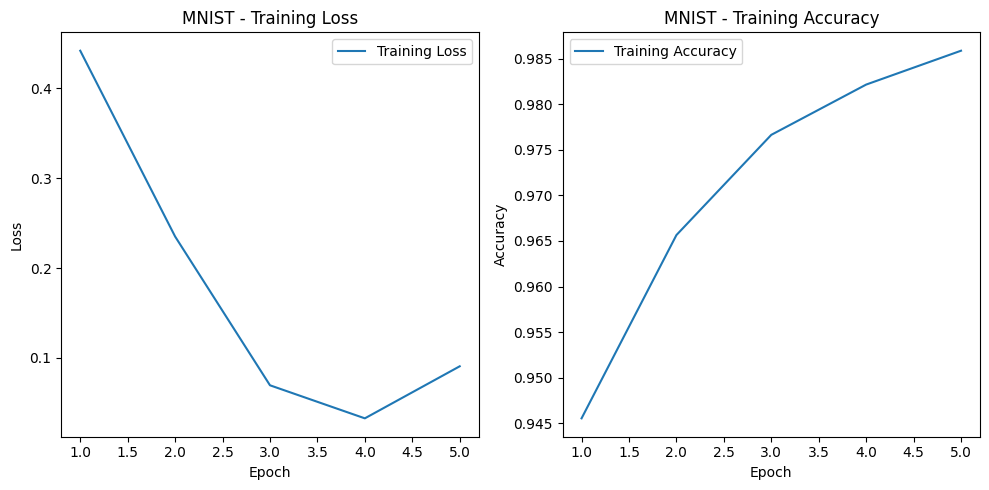

In [28]:
# ve do thi loss va accuracy cho MNIST
epochs = range(1, len(mnist_loss)+1)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, mnist_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MNIST - Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, mnist_acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MNIST - Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Phan 2: Train Cat and Dog voi ANN

In [29]:
# import them thu vien cho Cat and Dog
from torchvision import transforms
from torchvision.datasets import ImageFolder
import os

In [30]:
# dinh nghia transform cho anh Cat and Dog
# resize anh ve 64x64 va chuyen thanh tensor
transform_catdog = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [31]:
# tai du lieu Cat and Dog
# luu y: can thay doi duong dan phu hop voi thu muc du lieu cua ban
# cau truc thu muc: data/catdog/train/cat/, data/catdog/train/dog/
#                   data/catdog/test/cat/, data/catdog/test/dog/

data_dir = './data/catdog'

# kiem tra thu muc ton tai
if os.path.exists(data_dir):
    train_catdog = ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform_catdog)
    test_catdog = ImageFolder(root=os.path.join(data_dir, 'test'), transform=transform_catdog)
    
    train_loader_catdog = DataLoader(dataset=train_catdog, batch_size=32, shuffle=True)
    test_loader_catdog = DataLoader(dataset=test_catdog, batch_size=32, shuffle=False)
    
    print(f'So luong anh train: {len(train_catdog)}')
    print(f'So luong anh test: {len(test_catdog)}')
    print(f'Cac class: {train_catdog.classes}')
else:
    print(f'Chua co thu muc {data_dir}')
    print('Vui long tao thu muc va them anh cat/dog vao')

Chua co thu muc ./data/catdog
Vui long tao thu muc va them anh cat/dog vao


In [32]:
# dinh nghia mo hinh ANN cho Cat and Dog
class ANN_CatDog(nn.Module):
    def __init__(self):
        super(ANN_CatDog, self).__init__()
        self.flatten = nn.Flatten()  # chuyen anh 64x64x3 thanh vector 12288
        self.fc1 = nn.Linear(64*64*3, 256)  # lop an thu nhat
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 64)  # lop an thu hai
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 2)  # lop dau ra 2 class (cat, dog)
        # Khong dung Softmax vi CrossEntropyLoss da tinh roi
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [33]:
# train mo hinh Cat and Dog (chi chay khi co du lieu)
if os.path.exists(data_dir):
    model_catdog = ANN_CatDog().to(device)
    criterion_catdog = nn.CrossEntropyLoss()
    optimizer_catdog = optim.Adam(model_catdog.parameters(), lr=0.001)
    
    print('Training Cat and Dog')
    catdog_loss, catdog_acc = train_model(model_catdog, train_loader_catdog, test_loader_catdog, 
                                           criterion_catdog, optimizer_catdog, num_epochs=10)
else:
    print('Khong the train vi khong co du lieu Cat and Dog')

Khong the train vi khong co du lieu Cat and Dog


In [34]:
# ve do thi loss va accuracy cho Cat and Dog
if os.path.exists(data_dir):
    epochs = range(1, len(catdog_loss)+1)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, catdog_loss, label='Training Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Cat and Dog - Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, catdog_acc, label='Training Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Cat and Dog - Training Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()